# 27.2 The Take-Home Challenge (Ultimate)
<br>

For this take home challenge we were tasked with finding the best predictors for retention, and to provide Ultimate with suggestions to operationalize our insights. We started by performing an EDA of our dataset ("logins.json"). Our EDA consisted of various subplots containing counts of the login data, line plots exemplifying the change in logins over time and category plots showing avg amounts of logins. The plots provide a easy way to visualize the significance of change over a certain period of time. It was a good starting point of investigation, revealing some interesting details right away. From there we moved on to "Part 2 - Experiment and Metrics Design", where we tackle issues of experimentation for Ultimate, choosing a measure that will accurately measure its success. After answering their questions we dive deep into the data and prepare to build our models. 
<br>

**We built two models:**
   - Random Forest Classifier
   - Support Vector Classifier
<br>  

**Ultimates retention rate:** 
    
    - 40%
    - Top contributor in features: avg_rating_by_driver


In [1]:
from IPython.display import display
import numpy as np
import pandas as pd
import pandas_profiling
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.svm import SVC
import scipy

%matplotlib inline
matplotlib.rc({"figure.dpi": 300, 'savefig.dpi': 300})
sns.set_style("ticks")
sns.set_theme(style="darkgrid")
sns.set_palette("muted")
new_style = {'grid': True}
matplotlib.rc('axes', **new_style)

# Part 1 - Exploratory Data Analysis

In [2]:
# load data
login_data = pd.read_json('./logins.json')
login_data['#_login'] = 1

# Convert the date to pandas datetime object
login_data = login_data.set_index(pd.to_datetime(
    login_data['login_time']))[['#_login']]
login_data.head()

#_login
login_time                  
1970-01-01 20:13:18        1
1970-01-01 20:16:10        1
1970-01-01 20:16:37        1
1970-01-01 20:16:36        1
1970-01-01 20:26:21        1

In [3]:
# Resample to 15Min and 60Min groups
logins_delta15 = login_data.resample('15Min').sum()
logins_delta60 = login_data.resample('60Min').sum()

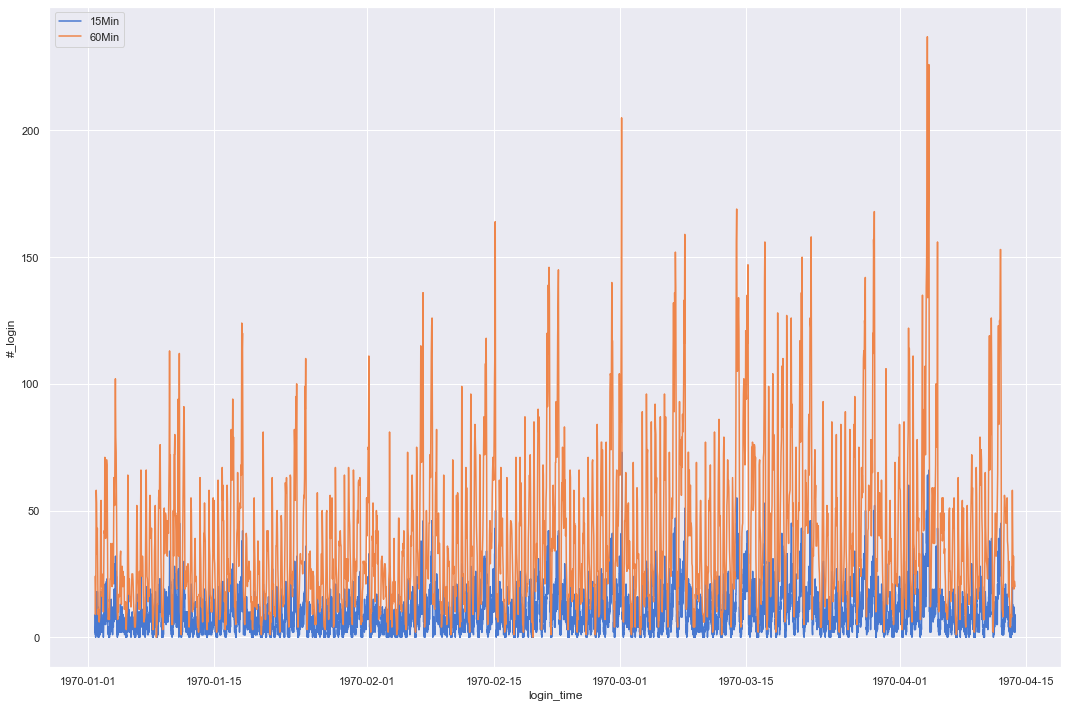

In [12]:
# Plot using lineplots

fig, ax = plt.subplots(figsize=(15, 10))
sns.lineplot(x=logins_delta15.index, y=logins_delta15['#_login'])
sns.lineplot(x=logins_delta60.index, y=logins_delta60['#_login'])

plt.legend(('15Min', '60Min'), loc='upper left')
plt.tight_layout()
plt.show()

In [13]:
# Seperate data by specific days

logins_daily = login_data.resample('D').sum()
logins_biz_day = login_data.resample('B').sum()
fridays = login_data.resample('W-FRI').sum()
saturdays = login_data.resample('W-SAT').sum()
sundays = login_data.resample('W-SUN').sum()

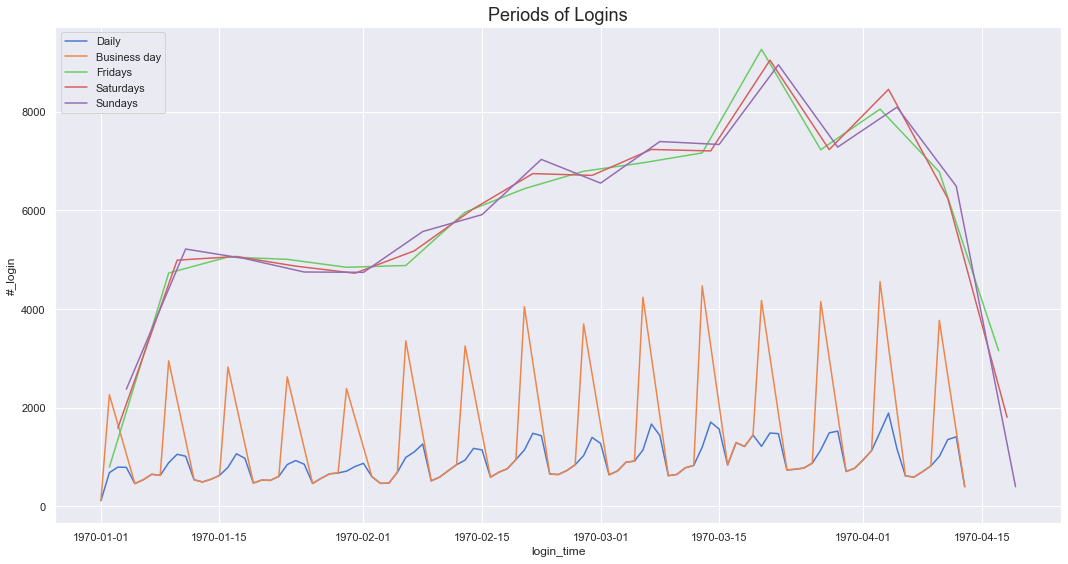

In [67]:
# Plot lineplots for each daily time period

fig, ax = plt.subplots(sharex=True, figsize=(15, 8))

sns.lineplot(data=logins_daily,
             x=logins_daily.index,
             y=logins_daily['#_login'])
sns.lineplot(data=logins_biz_day,
             x=logins_biz_day.index,
             y=logins_biz_day['#_login'])
sns.lineplot(data=fridays, x=fridays.index, y=fridays['#_login'])
sns.lineplot(data=saturdays, x=saturdays.index, y=saturdays['#_login'])
sns.lineplot(data=sundays, x=sundays.index, y=sundays['#_login'])

plt.legend(('Daily', 'Business day', 'Fridays', 'Saturdays', 'Sundays'),
           loc='upper left')
plt.title('Periods of Logins', fontsize=18)
plt.tight_layout()
plt.show()

In [39]:
# Resample hourly
daily_logins = login_data.resample('H').sum()
day_of_week = list(daily_logins.index.dayofweek)  # Column for each day of week
daily_logins['day_of_week'] = day_of_week
daily_logins['hour'] = [time.hour for time in daily_logins.index]  # Omit date

In [40]:
# Avg logins for each hour in a day

avg_hourly_logins = pd.pivot_table(daily_logins,
                                   values='#_login',
                                   index='hour',
                                   columns='day_of_week',
                                   aggfunc=np.mean).rename(
                                       columns={
                                           0: 'Monday',
                                           1: 'Tuesday',
                                           2: 'Wednesday',
                                           3: 'Thursday',
                                           4: 'Friday',
                                           5: 'Saturday',
                                           6: 'Sunday'
                                       })

avg_hourly_logins = avg_hourly_logins.stack(level=['day_of_week'])
avg_hourly_logins.name = 'avg_num_logins'
avg_hourly_logins_df = avg_hourly_logins.reset_index()

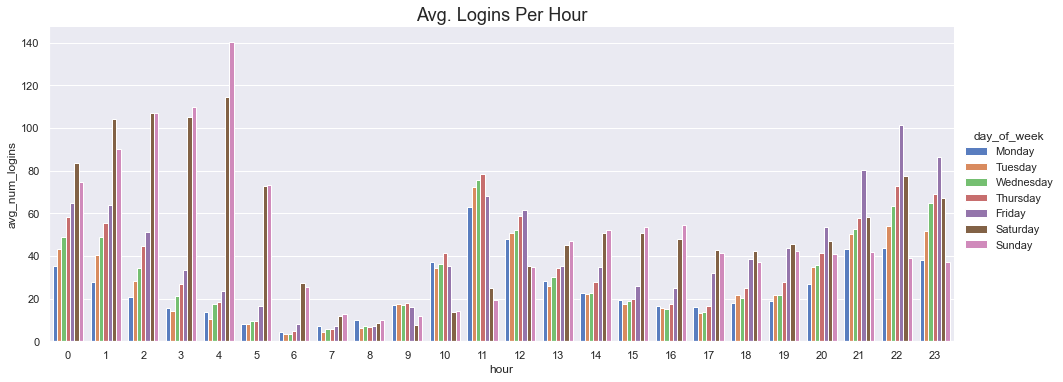

In [68]:
# Categorical bar plot

sns.catplot(x='hour',
            y='avg_num_logins',
            data=avg_hourly_logins_df,
            kind='bar',
            hue='day_of_week',
            aspect=40 / 15)

plt.title("Avg. Logins Per Hour", fontsize=18)
plt.show()

# Part 2 - Experiment and Metrics Design
<br>

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.
<br>

**1. What would you choose as the key measure of success of this experiment in
encouraging driver partners to serve both cities, and why would you choose this metric?**

A key measure of success for this experiment would be Ultimate to identify the difference in the amount of trips going to and coming back from each city. This would only be useful, however, if this observation was made once the experiment started to get going. By collecting more data on the experiment you'll be able to see more clearly over time if the amount of trips are increasing. If there was no increase over X amount of time than you'd quickly realize the experiment has failed or is starting to fail since the goal is to encourage driver partners to be available in both cities. Therefore, you should see a consistent increase in driver availability.
<br>

**2. Describe a practical experiment you would design to compare the effectiveness of the
proposed change in relation to the key measure of success. Please provide details on:**

    a. How you will implement the experiment?
    b. What statistical test(s) you will conduct to verify the significance of the
    observation?
    c. How you would interpret the results and provide recommendations to the city
    operations team along with any caveats.
<br>

A practical and efficient experiment to perform that will provide the observer with enough information to decide where to go moving forward would be to compute the average of the number of trips both before the toll experiment started and once it ended. The mean # of trips will show empirical evidence in a very simple way that's able to demonstrate clearly why the experiment was a success or not. then once the means are available, it would be necessary to compute the z-score of each sample. The z-score will provide a great way to evaluate significance in regard to averages. To interpret the results of our z-scores, we could say that if a large difference is not found, then the test has failed. On the other hand, if a difference is found that is substantial then one can conclude the experiment has been successful. 


# Part 3 - Predictive Modeling

In [36]:
# load data
df = pd.read_json("./ultimate_data_challenge.json")
df.head()

city  trips_in_first_30_days signup_date  avg_rating_of_driver  \
0  King's Landing                       4  2014-01-25                   4.7   
1         Astapor                       0  2014-01-29                   5.0   
2         Astapor                       3  2014-01-06                   4.3   
3  King's Landing                       9  2014-01-10                   4.6   
4      Winterfell                      14  2014-01-27                   4.4   

   avg_surge last_trip_date    phone  surge_pct  ultimate_black_user  \
0       1.10     2014-06-17   iPhone       15.4                 True   
1       1.00     2014-05-05  Android        0.0                False   
2       1.00     2014-01-07   iPhone        0.0                False   
3       1.14     2014-06-29   iPhone       20.0                 True   
4       1.19     2014-03-15  Android       11.8                False   

   weekday_pct  avg_dist  avg_rating_by_driver  
0         46.2      3.67                   5.0  
1         50.0      8.26                   5.0  
2        100.0      0.77                   5.0  
3         80.0      2.36                   4.9  
4         82.4      3.13                   4.9

In [37]:
print(df.dtypes)
print(len(df))

city                       object
trips_in_first_30_days      int64
signup_date                object
avg_rating_of_driver      float64
avg_surge                 float64
last_trip_date             object
phone                      object
surge_pct                 float64
ultimate_black_user          bool
weekday_pct               float64
avg_dist                  float64
avg_rating_by_driver      float64
dtype: object
50000


In [38]:
# Convert to pandas datetime object

df['signup_date'] = pd.to_datetime(df['signup_date'])
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])
df['city'] = df['city'].convert_dtypes(convert_string=True)
df['phone'] = df['phone'].convert_dtypes(convert_string=True)
df['ultimate_black_user'] = df['ultimate_black_user'].convert_dtypes(
    convert_string=True)

In [6]:
# Generate statistical report using "pandas profiler"

r = pandas_profiling.ProfileReport(df)
display(r)

In [39]:
# Drop NaNs and city column

df = df.dropna()
df.drop('city', axis=1, inplace=True)
print(len(df), df.dtypes)

41445 trips_in_first_30_days             int64
signup_date               datetime64[ns]
avg_rating_of_driver             float64
avg_surge                        float64
last_trip_date            datetime64[ns]
phone                             string
surge_pct                        float64
ultimate_black_user              boolean
weekday_pct                      float64
avg_dist                         float64
avg_rating_by_driver             float64
dtype: object


In [40]:
# One-hot-encode for phone and ultimate black user columns (Categorical)

df2 = pd.get_dummies(df,
                     columns=['phone', 'ultimate_black_user'],
                     drop_first=True)
df2.head()

trips_in_first_30_days signup_date  avg_rating_of_driver  avg_surge  \
0                       4  2014-01-25                   4.7       1.10   
1                       0  2014-01-29                   5.0       1.00   
2                       3  2014-01-06                   4.3       1.00   
3                       9  2014-01-10                   4.6       1.14   
4                      14  2014-01-27                   4.4       1.19   

  last_trip_date  surge_pct  weekday_pct  avg_dist  avg_rating_by_driver  \
0     2014-06-17       15.4         46.2      3.67                   5.0   
1     2014-05-05        0.0         50.0      8.26                   5.0   
2     2014-01-07        0.0        100.0      0.77                   5.0   
3     2014-06-29       20.0         80.0      2.36                   4.9   
4     2014-03-15       11.8         82.4      3.13                   4.9   

   phone_iPhone  ultimate_black_user_True  
0             1                         1  
1             0                         0  
2             1                         0  
3             1                         1  
4             0                         0

<AxesSubplot:xlabel='ultimate_black_user', ylabel='phone_iPhone'>

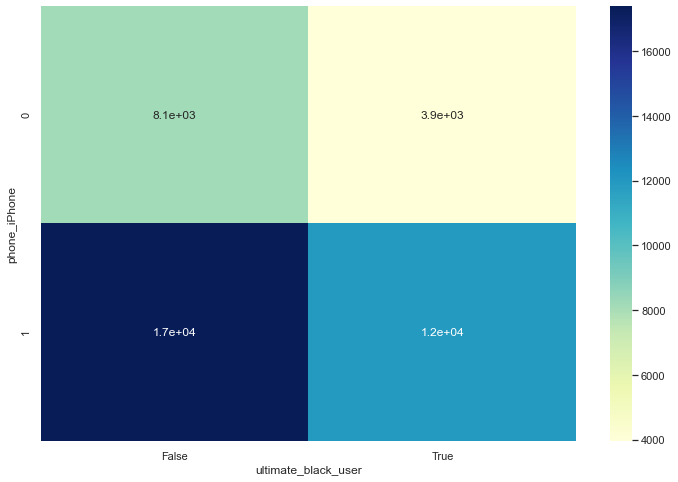

In [42]:
# Chi-squared test for categorical data

contigency = pd.crosstab(df2['phone_iPhone'], df['ultimate_black_user'])
plt.figure(figsize=(12, 8))
sns.heatmap(contigency, annot=True, cmap="YlGnBu")

In [50]:
# Chi-squared - p-value, DOF and expected (test of independence)

c, p, dof, expected = scipy.stats.chi2_contingency(contigency)
print("p-value:", p, "\ndegree of freedom:", dof, "\nexpected:\n", expected)

p-value: 2.69438848145635e-54 
degree of freedom: 1 
expected:
 [[ 7448.08584872  4644.91415128]
 [18077.91415128 11274.08584872]]


In [54]:
# Active and inactive users

pull_date = df2.last_trip_date.max()

# Time data was pulled
cut_off_day = pull_date - pd.Timedelta('30 days')
df2['active_status'] = (df2.last_trip_date > cut_off_day).astype('int')

# Seperate groups
active_user = df2[df2.active_status == 1]
inactive_user = df2[df2.active_status == 0]

In [55]:
# Calculate retention rate of users

retained = round(
    (len(active_user.active_status) / len(df2.active_status)) * 100, 2)
print('{} percent of users were retained.'.format(retained))

40.07 percent of users were retained.


In [56]:
df2.columns

Index(['trips_in_first_30_days', 'signup_date', 'avg_rating_of_driver',
       'avg_surge', 'last_trip_date', 'surge_pct', 'weekday_pct', 'avg_dist',
       'avg_rating_by_driver', 'phone_iPhone', 'ultimate_black_user_True',
       'active_status'],
      dtype='object')

In [120]:
# Descriptive statistics of features

feature_columns = [
    'trips_in_first_30_days', 'avg_rating_of_driver', 'avg_surge', 'surge_pct',
    'weekday_pct', 'avg_dist', 'avg_rating_by_driver', 'phone_iPhone',
    'ultimate_black_user_True'
]

df2[[
    'trips_in_first_30_days', 'signup_date', 'phone_iPhone',
    'ultimate_black_user_True', 'active_status'
]].describe()

trips_in_first_30_days  phone_iPhone  ultimate_black_user_True  \
count            41445.000000  41445.000000              41445.000000   
mean                 2.609675      0.708216                  0.384099   
std                  4.059336      0.454589                  0.486387   
min                  0.000000      0.000000                  0.000000   
25%                  0.000000      0.000000                  0.000000   
50%                  1.000000      1.000000                  0.000000   
75%                  3.000000      1.000000                  1.000000   
max                125.000000      1.000000                  1.000000   

       active_status  
count   41445.000000  
mean        0.400724  
std         0.490051  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         1.000000  
max         1.000000

In [63]:
sign_up = df2.sort_values('signup_date')

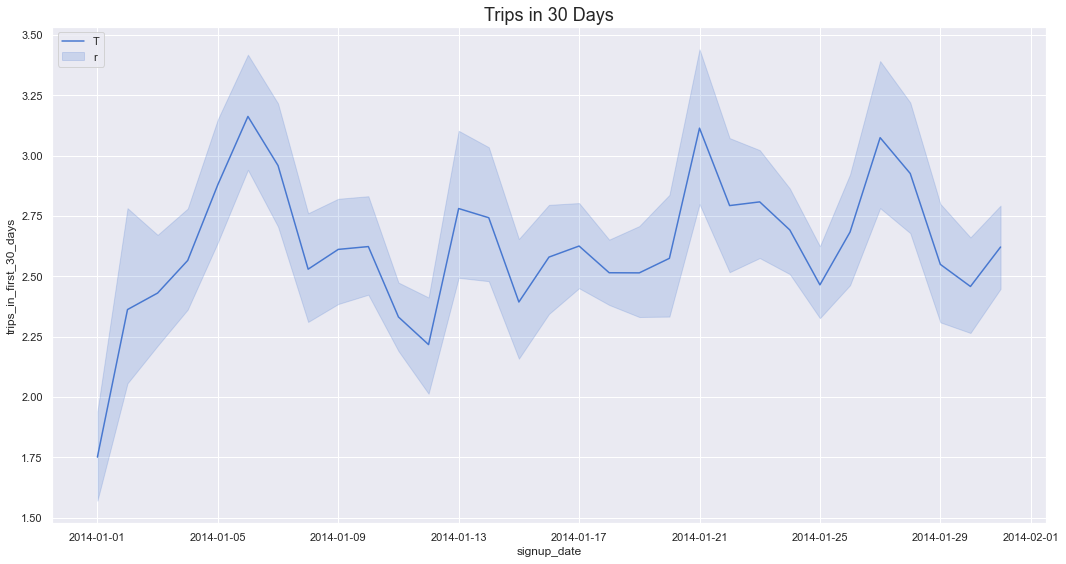

In [86]:
# Quick plot to visualize signup dates over time

fig, ax = plt.subplots(sharex=True, figsize=(15, 8))

sns.lineplot(data=sign_up, x='signup_date', y='trips_in_first_30_days')

plt.legend(('Trips first 30 days'), loc='upper left')
plt.title('Trips in 30 Days', fontsize=18)
plt.tight_layout()
plt.show()

In [142]:
# Perform train/test split (80/20)

X = df2[feature_columns]
y = df2['active_status']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=33)

In [143]:
# Views shapes and see split X,y

print("X_train:\n", X_train[0:3], X_train.shape, "\n", '\nX_test:\n',
      X_test[0:3], X_test.shape)
print("\n")
print("y_train:\n", y_train[0:3], y_train.shape, "\n", '\ny_test:\n',
      y_test[0:3], y_test.shape)

X_train:
        trips_in_first_30_days  avg_rating_of_driver  avg_surge  surge_pct  \
35567                       5                   5.0       1.03        3.1   
24793                       0                   4.8       1.00        0.0   
14989                       3                   4.1       1.00        0.0   

       weekday_pct  avg_dist  avg_rating_by_driver  phone_iPhone  \
35567         37.5      9.03                   4.8             1   
24793         40.0      4.54                   5.0             1   
14989         41.2      9.53                   4.6             1   

       ultimate_black_user_True  
35567                         0  
24793                         0  
14989                         1   (33156, 9) 
 
X_test:
        trips_in_first_30_days  avg_rating_of_driver  avg_surge  surge_pct  \
38279                       3                   4.5       1.25       40.0   
33640                       1                   3.7       1.10       13.3   
26525             

In [123]:
y_train = y_train.values.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1)

In [145]:
# Scale the data, fit and transform 

ss = MinMaxScaler(feature_range=(0, 1))

X_train = ss.fit_transform(X_train)
X_test = ss.fit_transform(X_test)

In [125]:
# Reshape 1D array for y_train

y_train = y_train.ravel()
y_train.shape

(33156,)

In [154]:
# Modeling GridSearch, fit pipeline

svc_params = {'kernel': ['rbf', 'poly'], 'C': [0.15, 1.5, 10]}

rfr_params = {
    'criterion': ["gini", "entropy"],
    'max_depth': [2, 3],
    "n_estimators": [300, 500, 700]
}

models = {
    'SVC':
    GridSearchCV(SVC(), param_grid=svc_params,
                 verbose=3).fit(X_train, y_train).best_estimator_,
    'RFR':
    GridSearchCV(RandomForestClassifier(), param_grid=rfr_params,
                 verbose=3).fit(X_train, y_train).best_estimator_
}

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] C=0.15, kernel=rbf ..............................................
[CV] .................. C=0.15, kernel=rbf, score=0.702, total=  32.6s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   32.5s remaining:    0.0s


[CV] C=0.15, kernel=rbf ..............................................
[CV] .................. C=0.15, kernel=rbf, score=0.703, total=  33.1s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min remaining:    0.0s


[CV] C=0.15, kernel=rbf ..............................................
[CV] .................. C=0.15, kernel=rbf, score=0.706, total=  31.7s
[CV] C=0.15, kernel=rbf ..............................................
[CV] .................. C=0.15, kernel=rbf, score=0.707, total=  32.1s
[CV] C=0.15, kernel=rbf ..............................................
[CV] .................. C=0.15, kernel=rbf, score=0.718, total=  31.2s
[CV] C=0.15, kernel=poly .............................................
[CV] ................. C=0.15, kernel=poly, score=0.700, total=  27.4s
[CV] C=0.15, kernel=poly .............................................
[CV] ................. C=0.15, kernel=poly, score=0.701, total=  24.2s
[CV] C=0.15, kernel=poly .............................................
[CV] ................. C=0.15, kernel=poly, score=0.705, total=  22.4s
[CV] C=0.15, kernel=poly .............................................
[CV] ................. C=0.15, kernel=poly, score=0.705, total=  24.1s
[CV] C

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 15.7min finished


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] criterion=gini, max_depth=2, n_estimators=300 ...................
[CV]  criterion=gini, max_depth=2, n_estimators=300, score=0.692, total=   3.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.1s remaining:    0.0s


[CV] criterion=gini, max_depth=2, n_estimators=300 ...................
[CV]  criterion=gini, max_depth=2, n_estimators=300, score=0.704, total=   3.1s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.2s remaining:    0.0s


[CV] criterion=gini, max_depth=2, n_estimators=300 ...................
[CV]  criterion=gini, max_depth=2, n_estimators=300, score=0.705, total=   3.1s
[CV] criterion=gini, max_depth=2, n_estimators=300 ...................
[CV]  criterion=gini, max_depth=2, n_estimators=300, score=0.709, total=   3.2s
[CV] criterion=gini, max_depth=2, n_estimators=300 ...................
[CV]  criterion=gini, max_depth=2, n_estimators=300, score=0.707, total=   3.6s
[CV] criterion=gini, max_depth=2, n_estimators=500 ...................
[CV]  criterion=gini, max_depth=2, n_estimators=500, score=0.697, total=   5.6s
[CV] criterion=gini, max_depth=2, n_estimators=500 ...................
[CV]  criterion=gini, max_depth=2, n_estimators=500, score=0.704, total=   5.3s
[CV] criterion=gini, max_depth=2, n_estimators=500 ...................
[CV]  criterion=gini, max_depth=2, n_estimators=500, score=0.705, total=   5.1s
[CV] criterion=gini, max_depth=2, n_estimators=500 ...................
[CV]  criterion=gini, m

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  5.7min finished


In [155]:
models['SVC'].get_params()

{'C': 10,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [156]:
# Test scores

svc_pred = models['SVC'].predict(X_test)
print(classification_report(y_test, svc_pred))

              precision    recall  f1-score   support

           0       0.76      0.80      0.78      4947
           1       0.68      0.62      0.65      3342

    accuracy                           0.73      8289
   macro avg       0.72      0.71      0.71      8289
weighted avg       0.72      0.73      0.72      8289



In [157]:
models['RFR'].get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 3,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 300,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [158]:
# Test scores

rfr_pred = models['RFR'].predict(X_test)
print(classification_report(y_test, ada_pred))

              precision    recall  f1-score   support

           0       0.74      0.87      0.80      4947
           1       0.73      0.55      0.63      3342

    accuracy                           0.74      8289
   macro avg       0.74      0.71      0.71      8289
weighted avg       0.74      0.74      0.73      8289



In [183]:
# Get feature imprtance of best performaning model

feat_importance = models['RFR'].feature_importances_

cols = []
for (f, c) in zip(feat_importance, feature_columns):
    cols.append((f,c))

feat_importance_df = pd.DataFrame(cols, columns=['feature_importance', 'feature'])
feat_importance_df.sort_values('feature_importance')

feature_importance                   feature
5            0.002032                  avg_dist
1            0.005333      avg_rating_of_driver
0            0.018491    trips_in_first_30_days
8            0.065917  ultimate_black_user_True
4            0.111433               weekday_pct
7            0.121593              phone_iPhone
2            0.157343                 avg_surge
3            0.209079                 surge_pct
6            0.308780      avg_rating_by_driver

# Findings
<br>

Our analysis, end to end resulted in two different models, a Support Vector Classifier and a Random Forest Classifier. We chose to build these specific models because they are unsupervised and usually produce good results with classification problems. Even though, they are somewhat slower than other light weight models they are worth building because of their interpretable results alone without the need to produce coefficient calculations by hand or require transformations that can be prone to error. The RFC produced slightly better results than the SVC, only by a few points. Our weighted averages of our best model (RFC) were 0.74 for precision, 0.74 for recall and 0.73 for F1. These results are not ideal, however, if we were to perform another analysis once more with the information gained from this one we can expect a large improvement. That being said we extracted the feature importance for our RFC and it very clearly shows us that the "avg_rating_by_driver" was the most useful for the algorithm to predict rider retention. The second most import was "surge_pct" with "avg_surge" right behind it.

These results show us that for Ultimate to be successful and maintain a high rider retention, a large part of their business model relies on their partnered driver ratings, which is the best case scenario because its something that is "controllable" unlike the feature "iphone." If Ultimate partners with drivers who they believe will have a high rating, their retention should continue to grow. With a growing retention rate, Ultimate will then be able to make the changes necessary to catch "surges" which will also drive prices as it is another factor that contributes greatly to rider growth overall. 